In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-sorting-train/BBC News Train.csv
/kaggle/input/news-sorting-test/BBC News Test.csv


In [104]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
!pip install -U accelerate --quiet
from transformers import pipeline


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<h3> Reading the data </br>

In [105]:
df_train = pd.read_csv("/kaggle/input/new-sorting-train/BBC News Train.csv")

In [106]:
df_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<h1>Data description</h1></br>
**BBC News Train.csv** - the training set of 1490 records</br>
**BBC News Test.csv** - the test set of 736 records</br>
**BBC News Sample Solution.csv** - a sample submission file in the correct format</br>
<h3>Data fields</h3></br>
**ArticleId** - Article id unique # given to the record</br>
**Article** - text of the header and article</br>
**Category** - cateogry of the article (tech, business, sport, entertainment, politics/li>

In [107]:
df_train['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [108]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


**We can see that none of the column has any missing value.**

In [109]:
df_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

<Axes: >

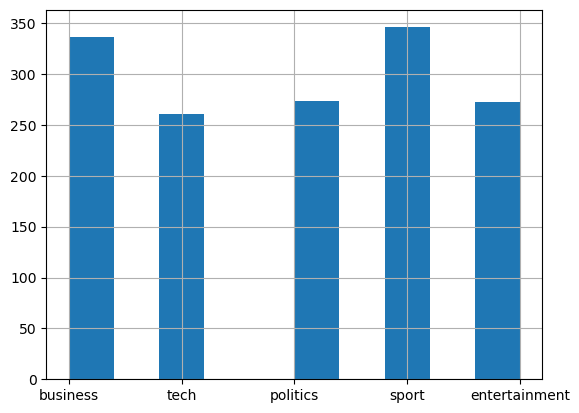

In [110]:
df_train['Category'].hist()

**As we see the length of each bin we can conclude that data is not imbalanced**

<h3> Text Preprocessing </h3>

In [111]:
target_map = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
df_train['target'] = df_train['Category'].map(target_map)


In [112]:
df_train.head()


,ArticleId,Text,Category,target
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,4
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [113]:
df_train_final = df_train[['Text', 'target']]
df_train_final.columns = ['sentence', 'label']



In [114]:
df_train_final.head()

,sentence,label
0,worldcom ex-boss launches defence lawyers defe...,0
1,german business confidence slides german busin...,0
2,bbc poll indicates economic gloom citizens in ...,0
3,lifestyle governs mobile choice faster bett...,4
4,enron bosses in $168m payout eighteen former e...,0


In [115]:
df_train_final.to_csv('train_final.csv')


In [116]:
raw_dataset = load_dataset('csv', data_files= 'train_final.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-649b8ede95881a46/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

In [117]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'sentence', 'label'],
        num_rows: 1490
    })
})

In [118]:
train = raw_dataset['train'].train_test_split(test_size= 0.3, seed = 42)

In [119]:
train

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'sentence', 'label'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['Unnamed: 0', 'sentence', 'label'],
        num_rows: 447
    })
})

<h3>Loading the model,tokenizer </h3>

In [120]:

checkpoint = 'google/bert_uncased_L-4_H-256_A-4'   #bert-mini



In [121]:
from transformers import AutoTokenizer,AutoConfig

In [122]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [123]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'] ,max_length = 512 ,truncation=True)

In [124]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



In [125]:
config = AutoConfig.from_pretrained(checkpoint)

In [126]:
config

BertConfig {
  "_name_or_path": "google/bert_uncased_L-4_H-256_A-4",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [127]:
config.id2label = {0 : "LABEL_0", 1: "LABEL_1", 2:"LABEL_2", 3: "LABEL_3", 4:"LABEL_4"}

In [128]:
config.label2id = {"LABEL_0":0, "LABEL_1": 1, "LABEL_2": 2, "LABEL_3": 3, "LABEL_4":4 }


In [129]:
config.id2label = {v:k for k,v in target_map.items()}


In [130]:
config.label2id = target_map

In [131]:
tokenized_datasets = train.map(tokenize_fn, batched= True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [132]:
from transformers import AutoModelForSequenceClassification, Trainer,TrainingArguments

In [133]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config)

Some weights of the model checkpoint at google/bert_uncased_L-4_H-256_A-4 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [134]:
#pip install torchinfo

In [135]:
from torchinfo import summary

In [136]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              7,813,632
│    │    └─Embedding: 3-2                              131,072
│    │    └─Embedding: 3-3                              512
│    │    └─LayerNorm: 3-4                              512
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             3,159,040
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 65,792
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           1,285
Total params: 11,171,84

<h3> Training the model </h3>

In [137]:
training_args = TrainingArguments(
    output_dir = 'training_dir',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64
)

In [138]:


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels,predictions, average = 'macro')
    return {'accuracy': acc, 'f1_score': f1}


In [139]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    data_collator=data_collator,
    compute_metrics = compute_metrics
)

In [140]:
import wandb
wandb. init(mode="disabled")

In [141]:
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
1,No log,0.676749,0.939597,0.938851
2,No log,0.295993,0.970917,0.970941
3,No log,0.167684,0.968680,0.969057
4,No log,0.158904,0.959732,0.959490
5,No log,0.131413,0.964206,0.963766
6,No log,0.121896,0.970917,0.971105
7,No log,0.118783,0.973154,0.973140
8,0.269000,0.113937,0.973154,0.973140
9,0.269000,0.115604,0.973154,0.973140
10,0.269000,0.115150,0.973154,0.973140


TrainOutput(global_step=660, training_loss=0.2099291165669759, metrics={'train_runtime': 73.5405, 'train_samples_per_second': 141.827, 'train_steps_per_second': 8.975, 'total_flos': 103358096949618.0, 'train_loss': 0.2099291165669759, 'epoch': 10.0})

**We can see that accuracy and f1_score has plateaued from 7th iteration but from 9th iteration there is increase in validation loss,so we choose 8th model as our best model.
8th model is checkpoint-528**

<h3> Doing Prediction <h3>

**Loading the trained model**

In [151]:
saved_model = pipeline('text-classification', model = '/kaggle/working/training_dir/checkpoint-528',device = 0)

In [143]:
#!pip install xformers

**Processing the input data for prediction**

In [152]:
def prediction(text):
    ids = tokenizer(text,max_length = 512, truncation = True)
    processed_text = tokenizer.decode(ids['input_ids'][1:-1])
    result = saved_model(processed_text)
    return result



    
    
    

In [153]:
df_text = pd.read_csv("/kaggle/input/news-sorting-test/BBC News Test.csv")

In [164]:
text_series = df_text['Text']

In [155]:
pred = series1.map(prediction)

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [159]:
label = []
score = []
for i in pred.values:
    label.append(i[0]['label'])
    score.append(i[0]['score'])


In [166]:
output = pd.DataFrame(list(zip(text_series,label,score)),columns = ['text','label', 'score'])

In [169]:
output.head()

,text,label,score
0,qpr keeper day heads for preston queens park r...,sport,0.984333
1,software watching while you work software that...,tech,0.979125
2,d arcy injury adds to ireland woe gordon d arc...,sport,0.984797
3,india s reliance family feud heats up the ongo...,business,0.984485
4,boro suffer morrison injury blow middlesbrough...,sport,0.984803


In [168]:
output_csv = output.to_csv()

In [172]:
#!zip -r file.zip /kaggle/working



In [171]:
#from IPython.display import FileLink
#FileLink(r'file.zip')


/kaggle/working/file.zip